In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
# 标明哪些列是数值型，哪些是类别型
# from torch import le

category_columns = ['Sex', 'Diagnostic', 'Stage', 'Surgury', 'Chemo', 'Radiotherapy', 'Drug', 'MSI', 'GeneMutation']
numeric_columns = ['Age', 'BMI', 'NLR', 'HGB', 'CPS', 'ki67']
hospital_source = ['Source']
target = ['Response']
data = pd.read_csv("digestive_cancer.csv")
# 由于MSI和GeneMutation是类别型变量，但由于存在缺失值，导致其数据类型是float64,因此需要先将数据类型转换为str，然后进行编码
data['MSI'] = data['MSI'].astype(str)
data['GeneMutation'] = data['GeneMutation'].astype(str)
# 对类别型变量进行编码
# 为每个需要编码的列创建独立的编码器
diagnostic_encoder = LabelEncoder()
msi_encoder = LabelEncoder()
mutation_encoder = LabelEncoder()
# 分别对每列进行编码
data['Diagnostic'] = diagnostic_encoder.fit_transform(data['Diagnostic'])
data['MSI'] = msi_encoder.fit_transform(data['MSI'])
data['GeneMutation'] = mutation_encoder.fit_transform(data['GeneMutation'])
y = data['Response']
scale_pos_weight = np.sum(y == 0) / np.sum(y == 1)  # 负类样本数 / 正类样本数
# 由于目前的数据集是将国内数据集和国外数据集合并到一起的，但两种数据集存在明显的差异，因此在划分训练集和测试集时，需要将两种数据集分开单独划分
data_in = data[data['Source'] == 1]
data_out = data[data['Source'] == 0]
# 由于在划分训练集和测试集时，需要保证训练集和测试集的类别分布是相同的，除此之外，还要保证每个类别中癌症类别的分布也是相同的，因此需要组建Diagnostic和Response的联合变量
data_in_stratify = data_in['Diagnostic'].astype(str) + '_' + data_in['Response'].astype(str)
data_out_stratify = data_out['Diagnostic'].astype(str) + '_' + data_out['Response'].astype(str)
# 区分数据的特征和目标
data_in_X = data_in.drop(columns=['Response', 'Source'])
data_in_y = data_in['Response']
data_out_X = data_out.drop(columns=['Response', 'Source'])
data_out_y = data_out['Response']
# 划分训练集和测试集
data_in_train_X, data_in_test_X, data_in_train_y, data_in_test_y = train_test_split(data_in_X, data_in_y, test_size=0.2, random_state=42, stratify=data_in_stratify)
data_out_train_X, data_out_test_X, data_out_train_y, data_out_test_y = train_test_split(data_out_X, data_out_y, test_size=0.2, random_state=42, stratify=data_out_stratify)
# 将两家医院的数据进行合并
data_train_X = pd.concat([data_in_train_X, data_out_train_X], ignore_index=True)
data_train_y = pd.concat([data_in_train_y, data_out_train_y], ignore_index=True)
data_test_X = pd.concat([data_in_test_X, data_out_test_X], ignore_index=True)
data_test_y = pd.concat([data_in_test_y, data_out_test_y], ignore_index=True)
# print("训练集的样本数:", len(data_train_X))
# print("测试集的样本数:", len(data_test_X))
# print("训练集的国内样本数:", len(data_in_train_X), "训练集的国外样本数:", len(data_out_train_X))
# print("测试集的国内样本数:", len(data_in_test_X), "测试集的国外样本数:", len(data_out_test_X))
# print("训练集的阳性样本数:", sum(data_train_y==1), "训练集的阴性样本数:", sum(data_train_y==0))
# print("测试集的阳性样本数:", sum(data_test_y==1), "测试集的阴性样本数:", sum(data_test_y==0))

# 查看癌症类别的数量和所占的百分比
# print(data_train_y.value_counts())
# print(data_test_y.value_counts())
# print(data_train_y["Response"].value_counts())
# print(data_test_y["Response"].value_counts())

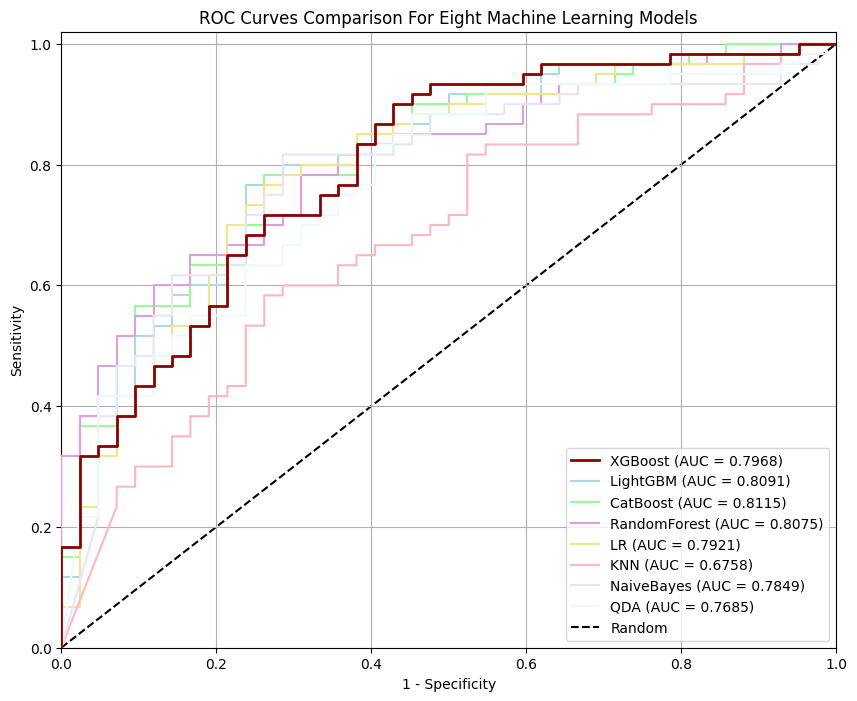

In [3]:
# 设置模型名称列表
model_names = ['XGBoost', 'LightGBM', 'CatBoost', 'RandomForest', 'LR', 'KNN', 'NaiveBayes', 'QDA']  # XGBoost在最前面
# 创建图形
plt.figure(figsize=(10, 8))

# 设置浅色调色板
light_colors = ['#ADD8E6', '#98FB98', '#DDA0DD', '#F0E68C', '#FFB6C1', '#E6E6FA', '#F0F8FF']
color_dict = dict(zip(model_names[1:], light_colors))  # 从第二个模型开始的颜色映射

# 为每个模型计算并绘制ROC曲线
for model_name in model_names:
    # 加载预测结果
    predictions = np.load(f'prediction/{model_name}_prediction.npy')
    
    # 计算ROC曲线
    fpr, tpr, thresholds = roc_curve(y_true=data_test_y, y_score=predictions[:, 1])
    roc_auc = auc(fpr, tpr)
    
    # 绘制ROC曲线，XGBoost使用深红色并确保显示在顶层，其他模型使用浅色
    if model_name == 'XGBoost':
        plt.plot(fpr, tpr, color='darkred', linewidth=2, label=f'{model_name} (AUC = {roc_auc:.4f})', zorder=10)
    else:
        plt.plot(fpr, tpr, color=color_dict[model_name], linewidth=1.5, label=f'{model_name} (AUC = {roc_auc:.4f})', zorder=5)

# 绘制对角线
plt.plot([0, 1], [0, 1], 'k--', label='Random', zorder=1)

# 设置图形属性
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('1 - Specificity')
plt.ylabel('Sensitivity')
plt.title('ROC Curves Comparison For Eight Machine Learning Models')
plt.legend(loc="lower right")
plt.grid(True)
# 保存图片
plt.savefig('figure/roc_curves.pdf', format='pdf', bbox_inches='tight', dpi=600)
plt.savefig('figure/roc_curves.svg', format='svg', bbox_inches='tight')

plt.show()

In [4]:
import numpy as np
from scipy import stats
from itertools import combinations
import pandas as pd
from sklearn.metrics import roc_curve, auc

def compute_delong_test(y_true, y1_pred, y2_pred):
    """
    计算两个模型预测结果的DeLong检验
    参数:
    y_true: 真实标签
    y1_pred: 模型1的预测概率
    y2_pred: 模型2的预测概率
    """
    # 获取正类和负类的索引
    pos_idx = np.where(y_true == 1)[0]
    neg_idx = np.where(y_true == 0)[0]
    
    # 计算每个预测值对所有正负样本对的贡献
    v10_1 = np.array([np.mean(y1_pred[pos_idx] > y1_pred[j]) for j in neg_idx])
    v10_2 = np.array([np.mean(y2_pred[pos_idx] > y2_pred[j]) for j in neg_idx])
    
    # 计算差异
    v10_diff = v10_1 - v10_2
    
    # 计算方差
    variance = np.var(v10_diff)
    
    # 计算z统计量
    z_score = np.mean(v10_diff) / np.sqrt(variance / len(neg_idx))
    
    # 计算p值（双尾检验）
    p_value = 2 * (1 - stats.norm.cdf(abs(z_score)))
    
    return p_value

# 加载所有模型的预测结果
model_names = ['XGBoost', 'LightGBM', 'CatBoost', 'RandomForest', 'LR', 'KNN', 'NaiveBayes', 'QDA']
predictions = {}
for model_name in model_names:
    predictions[model_name] = np.load(f'prediction/{model_name}_prediction.npy')[:, 1]

# 创建一个空的DataFrame来存储结果
results = pd.DataFrame(index=model_names, columns=model_names)

# 计算所有模型对之间的DeLong检验
for model1, model2 in combinations(model_names, 2):
    p_value = compute_delong_test(data_test_y, 
                                predictions[model1], 
                                predictions[model2])
    
    # 将p值存储在DataFrame中
    results.loc[model1, model2] = p_value
    results.loc[model2, model1] = p_value

# 将对角线设置为1
np.fill_diagonal(results.values, 1.0)

# 设置显示格式
pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))

# 打印结果表格
print("\nDeLong Test P-values:")
print(results)

# 将结果保存到CSV文件
results.to_csv('delong_test_results.csv')

# 创建一个显示显著性标记的DataFrame
significance_matrix = pd.DataFrame(index=model_names, columns=model_names)
for model1 in model_names:
    for model2 in model_names:
        p_value = results.loc[model1, model2]
        if model1 == model2:
            significance_matrix.loc[model1, model2] = ''
        else:
            if p_value < 0.001:
                significance_matrix.loc[model1, model2] = '***'
            elif p_value < 0.01:
                significance_matrix.loc[model1, model2] = '**'
            elif p_value < 0.05:
                significance_matrix.loc[model1, model2] = '*'
            else:
                significance_matrix.loc[model1, model2] = 'ns'

print("\nStatistical Significance:")
print(significance_matrix)

# 将显著性矩阵保存到CSV文件
significance_matrix.to_csv('delong_test_significance.csv')



DeLong Test P-values:
             XGBoost LightGBM CatBoost RandomForest     LR    KNN NaiveBayes  \
XGBoost       1.0000   0.3478   0.4457       0.5417 0.8697 0.0003     0.5712   
LightGBM      0.3478   1.0000   0.8693       0.9277 0.5234 0.0002     0.3065   
CatBoost      0.4457   0.8693   1.0000       0.8519 0.4768 0.0006     0.1517   
RandomForest  0.5417   0.9277   0.8519       1.0000 0.5594 0.0004     0.3650   
LR            0.8697   0.5234   0.4768       0.5594 1.0000 0.0134     0.6505   
KNN           0.0003   0.0002   0.0006       0.0004 0.0134 1.0000     0.0240   
NaiveBayes    0.5712   0.3065   0.1517       0.3650 0.6505 0.0240     1.0000   
QDA           0.3394   0.1488   0.0619       0.1925 0.4383 0.0426     0.4508   

                QDA  
XGBoost      0.3394  
LightGBM     0.1488  
CatBoost     0.0619  
RandomForest 0.1925  
LR           0.4383  
KNN          0.0426  
NaiveBayes   0.4508  
QDA          1.0000  

Statistical Significance:
             XGBoost LightGBM C

In [5]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from scipy import stats

def calculate_auc_ci(y_true, y_pred, method='bootstrap', n_bootstraps=1000, confidence_level=0.95):
    """
    计算AUC及其置信区间
    
    参数:
    y_true: 真实标签
    y_pred: 预测概率
    method: 'bootstrap' 或 'delong'
    n_bootstraps: bootstrap重采样次数
    confidence_level: 置信水平
    
    返回:
    auc_value: AUC值
    ci_lower: 置信区间下限
    ci_upper: 置信区间上限
    """
    
    def bootstrap_auc():
        rng = np.random.RandomState(42)
        auc_values = []
        
        for i in range(n_bootstraps):
            # 有放回抽样
            indices = rng.randint(0, len(y_true), len(y_true))
            y_true_bootstrap = y_true[indices]
            y_pred_bootstrap = y_pred[indices]
            
            if len(np.unique(y_true_bootstrap)) < 2:
                continue
                
            fpr, tpr, _ = roc_curve(y_true_bootstrap, y_pred_bootstrap)
            auc_values.append(auc(fpr, tpr))
        
        # 计算置信区间
        ci_lower = np.percentile(auc_values, (1 - confidence_level) / 2 * 100)
        ci_upper = np.percentile(auc_values, (1 + confidence_level) / 2 * 100)
        
        return ci_lower, ci_upper
    
    def delong_auc_variance():
        """
        使用DeLong方法计算AUC的方差
        """
        # 获取正类和负类的索引
        pos_idx = np.where(y_true == 1)[0]
        neg_idx = np.where(y_true == 0)[0]
        
        n1 = len(pos_idx)
        n2 = len(neg_idx)
        
        # 计算每个预测值对所有正负样本对的贡献
        v10 = np.array([np.mean(y_pred[pos_idx] > y_pred[j]) for j in neg_idx])
        
        # 计算方差
        variance = np.var(v10) / n2
        
        return variance
    
    # 计算总体AUC
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_value = auc(fpr, tpr)
    
    # 根据选择的方法计算置信区间
    if method == 'bootstrap':
        ci_lower, ci_upper = bootstrap_auc()
    else:  # delong method
        variance = delong_auc_variance()
        z_score = stats.norm.ppf((1 + confidence_level) / 2)
        margin = z_score * np.sqrt(variance)
        ci_lower = auc_value - margin
        ci_upper = auc_value + margin
    
    return auc_value, ci_lower, ci_upper

# 使用示例
model_names = ['XGBoost', 'LightGBM', 'CatBoost', 'RandomForest', 'LR', 'KNN', 'NaiveBayes', 'QDA']
results = []

for model_name in model_names:
    # 加载预测结果
    predictions = np.load(f'prediction/{model_name}_prediction.npy')
    
    # 使用Bootstrap方法计算AUC及置信区间
    auc_bootstrap, ci_lower_bootstrap, ci_upper_bootstrap = calculate_auc_ci(
        data_test_y, 
        predictions[:, 1], 
        method='bootstrap'
    )
    
    # 使用DeLong方法计算AUC及置信区间
    auc_delong, ci_lower_delong, ci_upper_delong = calculate_auc_ci(
        data_test_y, 
        predictions[:, 1], 
        method='delong'
    )
    
    results.append({
        'Model': model_name,
        'AUC': auc_bootstrap,
        'Bootstrap_CI': f"({ci_lower_bootstrap:.4f}-{ci_upper_bootstrap:.4f})",
        'DeLong_CI': f"({ci_lower_delong:.4f}-{ci_upper_delong:.4f})"
    })

# 创建结果DataFrame并打印
results_df = pd.DataFrame(results)
print("\nAUC and 95% Confidence Intervals:")
print(results_df.to_string(index=False))

# 保存结果
results_df.to_csv('auc_confidence_intervals.csv', index=False)


AUC and 95% Confidence Intervals:
       Model    AUC    Bootstrap_CI       DeLong_CI
     XGBoost 0.7968 (0.7024-0.8785) (0.7275-0.8662)
    LightGBM 0.8091 (0.7131-0.8950) (0.7463-0.8719)
    CatBoost 0.8115 (0.7193-0.8911) (0.7506-0.8724)
RandomForest 0.8075 (0.7149-0.8868) (0.7536-0.8615)
          LR 0.7921 (0.6992-0.8733) (0.7228-0.8613)
         KNN 0.6758 (0.5696-0.7808) (0.5919-0.7597)
  NaiveBayes 0.7849 (0.6845-0.8725) (0.7156-0.8543)
         QDA 0.7685 (0.6573-0.8559) (0.6981-0.8388)


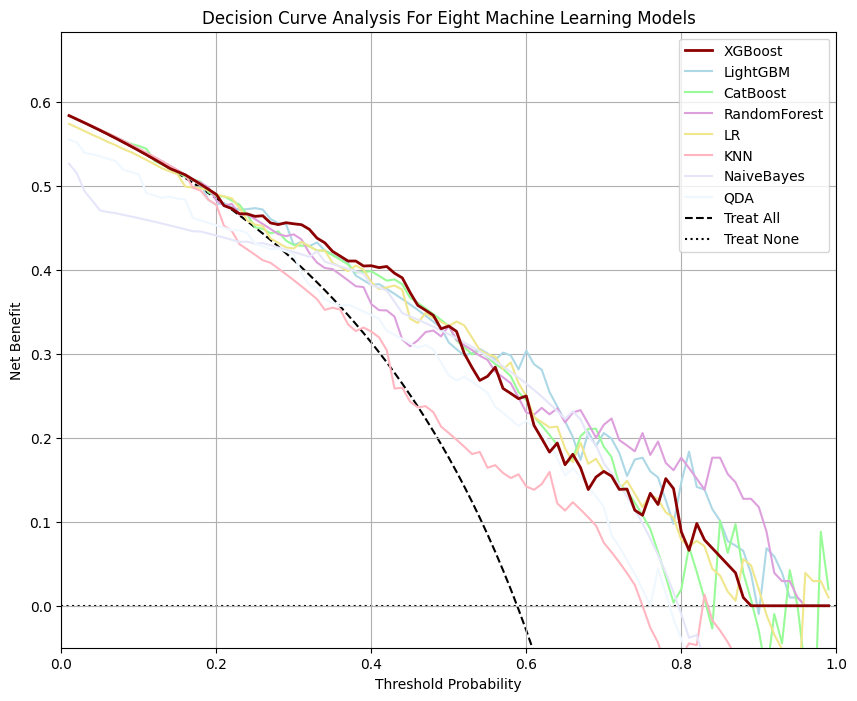

In [6]:
# 定义计算净获益的函数
def calculate_net_benefit(y_true, y_pred_prob, threshold):
    y_pred = (y_pred_prob >= threshold).astype(int)
    tn = np.sum((y_pred == 0) & (y_true == 0))
    fp = np.sum((y_pred == 1) & (y_true == 0))
    fn = np.sum((y_pred == 0) & (y_true == 1))
    tp = np.sum((y_pred == 1) & (y_true == 1))
    n = len(y_true)
    
    if tp + fp == 0:
        return 0
    
    net_benefit = (tp/n) - (fp/n) * (threshold/(1-threshold))
    return net_benefit

# 创建图形
plt.figure(figsize=(10, 8))

# 设置阈值范围
thresholds = np.arange(0.01, 1, 0.01)

# 计算和绘制每个模型的决策曲线
for model_name in model_names:
    # 加载预测结果
    predictions = np.load(f'prediction/{model_name}_prediction.npy')
    
    # 计算每个阈值下的净获益
    net_benefits = []
    for threshold in thresholds:
        nb = calculate_net_benefit(data_test_y, predictions[:, 1], threshold)
        net_benefits.append(nb)
    
    # 绘制决策曲线
    if model_name == 'XGBoost':
        plt.plot(thresholds, net_benefits, color='darkred', linewidth=2, 
                label=f'{model_name}', zorder=10)
    else:
        plt.plot(thresholds, net_benefits, color=color_dict[model_name], 
                linewidth=1.5, label=f'{model_name}', zorder=5)

# 添加"全部治疗"的基线
all_treat = []
for threshold in thresholds:
    nb = calculate_net_benefit(data_test_y, np.ones_like(data_test_y), threshold)
    all_treat.append(nb)
plt.plot(thresholds, all_treat, 'k--', label='Treat All', zorder=1)

# 添加"不治疗"的基线
plt.plot([0, 1], [0, 0], 'k:', label='Treat None', zorder=1)

# 设置图形属性
plt.xlim([0.0, 1.0])
plt.ylim([-0.05, max(all_treat) + 0.1])
plt.xlabel('Threshold Probability')
plt.ylabel('Net Benefit')
plt.title('Decision Curve Analysis For Eight Machine Learning Models')
plt.legend(loc='upper right')
plt.grid(True)

# 保存图片
plt.savefig('figure/decision_curves.pdf', format='pdf', bbox_inches='tight', dpi=600)
plt.savefig('figure/decision_curves.svg', format='svg', bbox_inches='tight')

plt.show()

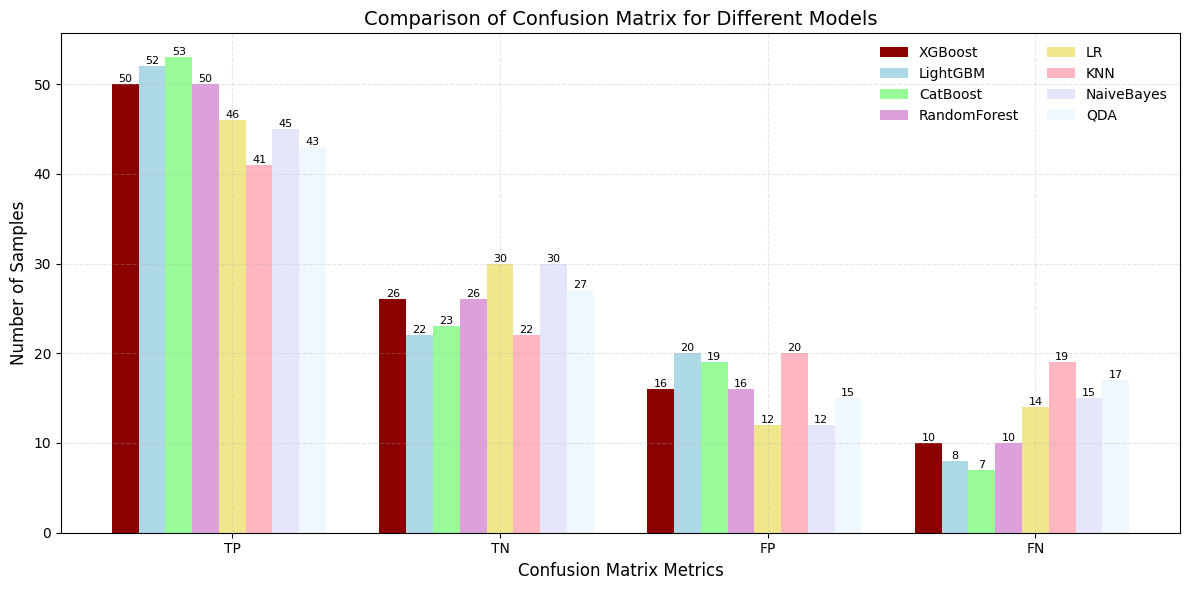

In [7]:
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix
# 设置模型名称列表和颜色
model_names = ['XGBoost', 'LightGBM', 'CatBoost', 'RandomForest', 'LR', 'KNN', 'NaiveBayes', 'QDA']
light_colors = ['darkred', '#ADD8E6', '#98FB98', '#DDA0DD', '#F0E68C', '#FFB6C1', '#E6E6FA', '#F0F8FF']
color_dict = dict(zip(model_names, light_colors))

# 创建存储混淆矩阵值的列表
metrics = ['TP', 'TN', 'FP', 'FN']
values_by_metric = {metric: [] for metric in metrics}

# 获取每个模型的混淆矩阵值
for model_name in model_names:
    predictions = np.load(f'prediction/{model_name}_prediction.npy')
    y_pred = np.argmax(predictions, axis=1)
    cm = confusion_matrix(y_true=data_test_y, y_pred=y_pred)
    
    values_by_metric['TN'].append(cm[0][0])
    values_by_metric['FP'].append(cm[0][1])
    values_by_metric['FN'].append(cm[1][0])
    values_by_metric['TP'].append(cm[1][1])

# 设置柱状图的位置
x = np.arange(len(metrics))
width = 0.1
total_width = width * len(model_names)
start = -(total_width/2)

# 创建图形
plt.figure(figsize=(12, 6))

# 绘制柱状图
for i, model_name in enumerate(model_names):
    position = x + start + i * width
    values = [values_by_metric[metric][i] for metric in metrics]
    bars = plt.bar(position, values, width, label=model_name, color=color_dict[model_name])
    
    # 在柱子上添加数值标签
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=8)

# 设置图形属性
plt.xlabel('Confusion Matrix Metrics', fontsize=12)
plt.ylabel('Number of Samples', fontsize=12)
plt.title('Comparison of Confusion Matrix for Different Models', fontsize=14)
plt.xticks(x, metrics)

# 添加网格线
plt.grid(True, linestyle='--', alpha=0.3)

# 创建图例，去掉外框
plt.legend(loc='upper right', ncol=2, frameon=False)

# 调整布局
plt.tight_layout()

# 保存图形
plt.savefig('figure/confusion_matrix_comparison.pdf', format='pdf', bbox_inches='tight', dpi=600)
plt.savefig('figure/confusion_matrix_comparison.svg', format='svg', bbox_inches='tight')

# 显示图形
plt.show()

In [8]:
import shap
import xgboost
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [9]:
# 加载weight/xgb_model.bin
model = xgboost.XGBClassifier()
model.load_model('weight/xgb_model.bin')
def cal_bin_metrics(y_true, y_pred):
    """
    the function is used to calculate the corresponding metrics for binary classification,
    including 二分类准确率, 灵敏度, 特异性, PPV, NPV, AUC
    :param y_true: 一维数组标签, [1, 0, 1, ...]
    :param y_pred: 二维预测数组, [num_sample, 2]
    :return:
    """
    y_pred = np.argmax(y_pred, axis=1)
    binary_accracy = accuracy_score(y_true=y_true, y_pred=y_pred)
    # 利用sklearn的接口计算得到混淆矩阵
    binary_confusion_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)
    # 接下来利用二分类的混淆矩阵计算各种指标，包括灵敏度，特异性，PPV, NPV
    tp = binary_confusion_matrix[1][1]
    fn = binary_confusion_matrix[1][0]
    fp = binary_confusion_matrix[0][1]
    tn = binary_confusion_matrix[0][0]
    sensitivity = tp / (tp + fn)
    specifity = tn / (tn + fp)
    ppv = tp / (tp + fp)
    npv = tn / (tn + fn)
    metrics = [binary_accracy, sensitivity, specifity, ppv, npv, binary_confusion_matrix]
    return metrics

predictions = model.predict_proba(data_test_X)
auc = roc_auc_score(y_true=data_test_y, y_score=predictions[:, 1])
print(auc)
metrics = cal_bin_metrics(y_true=data_test_y, y_pred=predictions)
print(metrics)


0.8289682539682539
[0.7843137254901961, 0.8666666666666667, 0.6666666666666666, 0.7878787878787878, 0.7777777777777778, array([[28, 14],
       [ 8, 52]])]


In [10]:
# 使用shape做可解释性分析
explainer = shap.Explainer(model)
shap_values = explainer(data_test_X)
import matplotlib.pyplot as plt

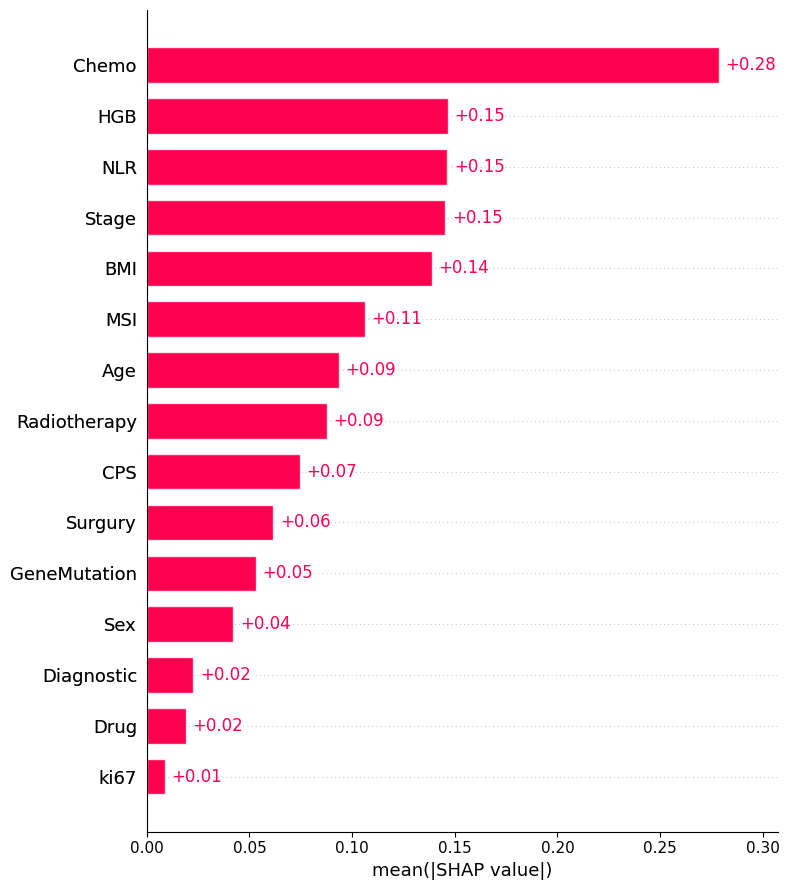

In [11]:
# 绘制柱状图
plt.figure(figsize=(12, 10))  # 调整图形大小
shap.plots.bar(shap_values, max_display=len(data_test_X.columns), show=False)
plt.tight_layout()
# 保存为PDF格式
plt.savefig('figure/shap_barplot.pdf', format='pdf', bbox_inches='tight', dpi=600)
# 保存为SVG格式
plt.savefig('figure/shap_barplot.svg', format='svg', bbox_inches='tight')
# 显示图形
plt.show()

In [12]:
print(data_test_y)

0      1
1      0
2      1
3      0
4      1
      ..
97     0
98     0
99     1
100    0
101    1
Name: Response, Length: 102, dtype: int64


<Figure size 2000x400 with 0 Axes>

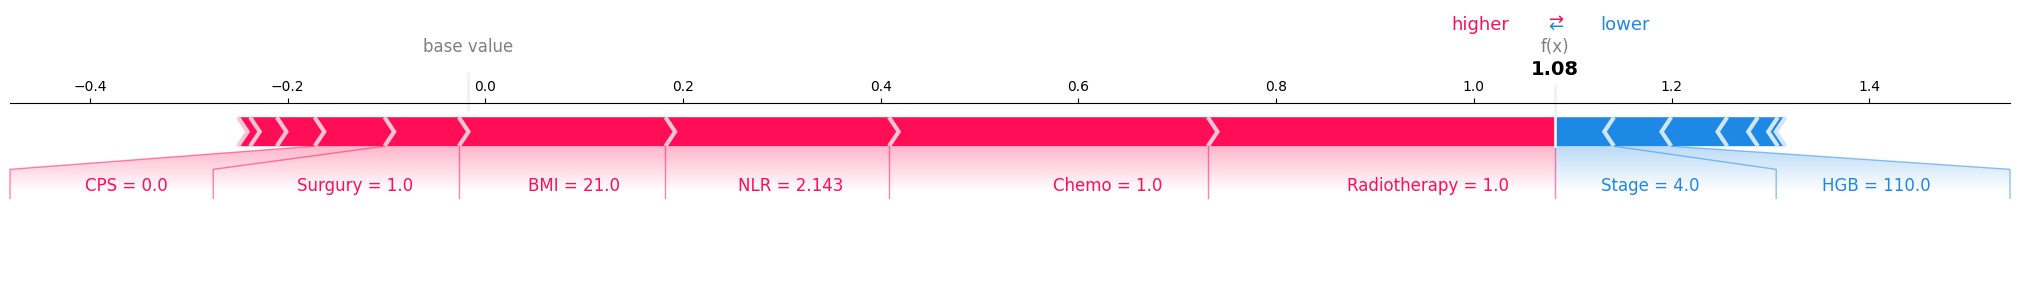

In [13]:
# 绘制力图
fig = plt.figure(figsize=(20, 4))  # 调整图形大小

# 绘制力图
shap.plots.force(shap_values[10], matplotlib=True, show=False)

# 增加上下边距
plt.margins(y=0.0)  # 增加垂直方向的边距
plt.tight_layout(pad=0.0)  # 增加边距参数

# 保存为PDF格式
plt.savefig('figure/shap_forceplot_postive.pdf', format='pdf', bbox_inches='tight', dpi=600)
# 保存为SVG格式
plt.savefig('figure/shap_forceplot_postive.svg', format='svg', bbox_inches='tight')
# 显示图形
plt.show()

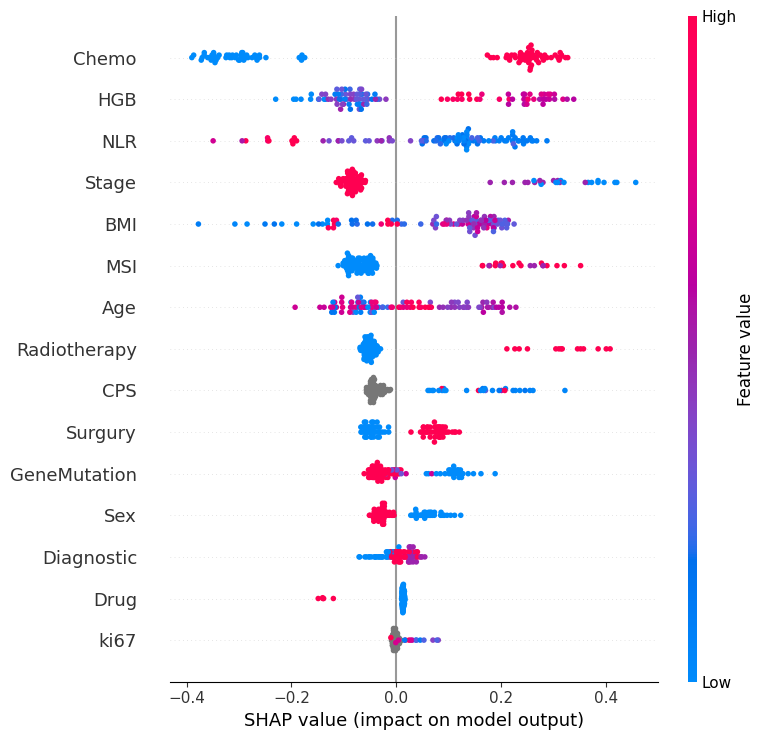

In [14]:
# 绘制蜂巢图
plt.figure(figsize=(12, 10))  # 调整图形大小
shap.plots.beeswarm(shap_values, max_display=len(data_test_X.columns), show=False)
plt.tight_layout()
# 保存为PDF格式
plt.savefig('figure/shap_beeswarm.pdf', format='pdf', bbox_inches='tight', dpi=600)
# 保存为SVG格式
plt.savefig('figure/shap_beeswarm.svg', format='svg', bbox_inches='tight')
# 显示图形
plt.show()